## PyMC geomod 2: Incorporating the Geological model to the Bayesian Model in PyMC

This notebook explains how we can generate the whole model at every step of our Bayesian Inference. This will allow us to create much more complex constrains to reduce the uncertainty.

**Importing**

In [1]:
%matplotlib inline
from IPython.core.display import Image

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import shutil
#import geobayes_simple as gs

import pymc as pm # PyMC 2
from pymc.Matplot import plot
from pymc import graph as gr
import numpy as np
#import daft
from IPython.core.pylabtools import figsize
figsize(12.5, 10)

Couldn't import dot_parser, loading of dot files will not be possible.


In [3]:
# as we have our model and pygeomod in different paths, let's change the pygeomod path to the default path.
sys.path.append("C:\Users\Miguel\workspace\pygeomod\pygeomod")
#sys.path.append(r'/home/jni/git/tmp/pygeomod_tmp')
import geogrid
import geomodeller_xml_obj as gxml
reload(gxml)


<module 'geomodeller_xml_obj' from 'C:\Users\Miguel\workspace\pygeomod\pygeomod\geomodeller_xml_obj.pyc'>

### Coping our Model in a new folder

In [4]:
try:
    shutil.copytree('C:/Users/Miguel/workspace/Thesis/Geomodeller/Basic_case/3_horizontal_layers', 'Temp_test/')
except:
    print "The folder is already created"

The folder is already created


## Simplest case: three horizontal layers, with depth unknow
#### Loading pre-made Geomodeller model 

    You have to be very careful with the path, and all the bars to the RIGHT

In [5]:
hor_lay = 'Temp_test/horizontal_layers.xml'#C:\Users\Miguel\workspace\Thesis\Thesis\Temp3
print hor_lay

Temp_test/horizontal_layers.xml


In [6]:
reload(geogrid)
G1 = geogrid.GeoGrid()

# Using G1, we can read the dimensions of our Murci geomodel
G1.get_dimensions_from_geomodeller_xml_project(hor_lay)

#G1.set_dimensions(dim=(0,23000,0,16000,-8000,1000))
nx = 400
ny = 2
nz = 400
G1.define_regular_grid(nx,ny,nz)

In [7]:
G1.update_from_geomodeller_project(hor_lay)

Tha axis here represent the number of cells not the real values of geomodeller

C:\Users\Miguel\Anaconda\lib\site-packages\matplotlib\axes\_base.py:1057: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
C:\Users\Miguel\Anaconda\lib\site-packages\matplotlib\axes\_base.py:1062: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


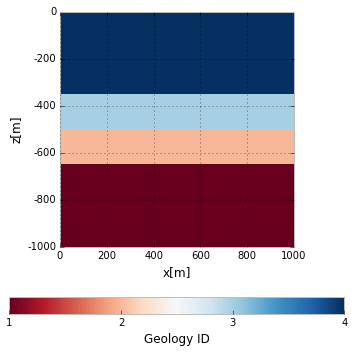

In [8]:
G1.plot_section('y',cell_pos=1,colorbar = True,  cmap='RdBu', figsize=(6,6),interpolation= 'nearest' ,ve = 1, geomod_coord= True)

#### Setting Bayes Model

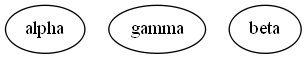

In [10]:
Image("Nice Notebooks\THL_no_thickness.png")

In [8]:
alpha = pm.Normal("alpha", -350, 0.05)
alpha

<pymc.distributions.Normal 'alpha' at 0x0000000019E24F98>

In [9]:
alpha = pm.Normal("alpha", -350, 0.05)# value= -250)

#Thickness of the layers
thickness_layer1 = pm.Normal("thickness_layer1", -150, 0.005) # a lot of uncertainty so the constrains are necessary
thickness_layer2 = pm.Normal("thickness_layer2", -150, 0.005)


@pm.deterministic
def beta(alpha = alpha, thickness_layer1 = thickness_layer1):
    return alpha + thickness_layer1

@pm.deterministic
def gamma(beta = beta, thickness_layer2 = thickness_layer2):
    return beta + thickness_layer2


@pm.deterministic
def section(alpha = alpha, beta = beta, gamma = gamma):
    # Create the array we will use to modify the xml
    samples =  [alpha,beta, gamma,alpha,beta, gamma]
    
    # Load the xml to be modify
    hor_lay = 'Temp_test\horizontal_layers.xml'
    
    #Create the instance to modify the xml
        # Loading stuff
    reload(gxml)
    gmod_obj = gxml.GeomodellerClass()
    gmod_obj.load_geomodeller_file(hor_lay)
    
    # Create a dictionary so we can acces the section through the name
    section_dict = gmod_obj.create_sections_dict()
    
    # ## Get the points of all formation for a given section: Dictionary
    contact_points = gmod_obj.get_formation_point_data(section_dict['Section1'])
    
    #Perform the position Change
    for i, point in enumerate(contact_points):
        gmod_obj.change_formation_point_pos(point, y_coord = [samples[i],samples[i]])
    
    # Check the new position of points
              #points_changed = gmod_obj.get_point_coordinates(contact_points)
              #print "Points coordinates", points_changed
    
    # Write the new xml
    gmod_obj.write_xml("Temp_test/new.xml")
    
    
    
    # Read the new xml
    hor_lay_new = 'Temp_test/new.xml'
    G1 = geogrid.GeoGrid()
    
    # Getting dimensions and definning grid
    
    G1.get_dimensions_from_geomodeller_xml_project(hor_lay_new)
    
    # Resolution!
    nx = 2
    ny = 2
    nz = 400
    G1.define_regular_grid(nx,ny,nz)
    
    # Updating project
    G1.update_from_geomodeller_project(hor_lay_new)
    
    # Printing new model
   # G1.plot_section('y',cell_pos=1,colorbar = True,  cmap='RdBu', figsize=(6,6),interpolation= 'nearest' ,ve = 1, geomod_coord= True)
    return G1

#MODEL!!
model = pm.Model([alpha, beta, gamma, section, thickness_layer1, thickness_layer2])

In [13]:
M = pm.MCMC(model)
M.sample(iter=100)

 [-----------------101%-----------------] 101 of 100 complete in 107.6 sec

** Extracting Posterior Traces to Arrays **

In [14]:
n_samples = 20

alpha_samples, alpha_samples_all = M.trace('alpha')[-n_samples:], M.trace("alpha")[:]
beta_samples, beta_samples_all = M.trace('beta')[-n_samples:], M.trace("beta")[:]
gamma_samples, gamma_samples_all = M.trace('gamma')[-n_samples:], M.trace('gamma')[:]
section_samples, section_samples_all = M.trace('section')[-n_samples:], M.trace('section')[:]

#print section_samples

** Plotting the results **

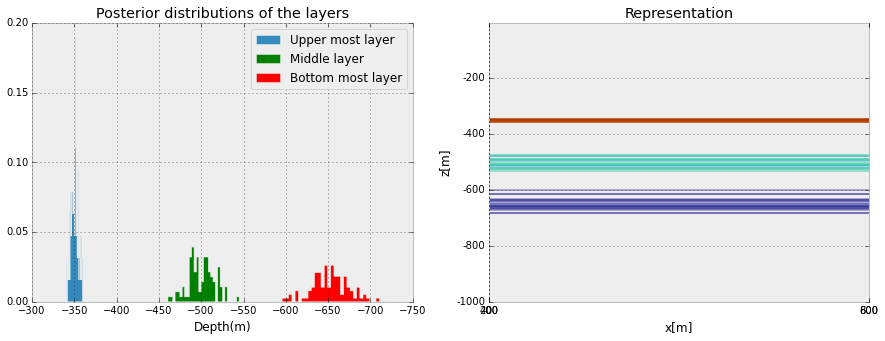

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(alpha_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Upper most layer", normed=True)
ax[0].hist(beta_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Middle layer", normed=True, color = "g")
ax[0].hist(gamma_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Bottom most layer", normed=True, color = "r")


ax[0].invert_xaxis()
ax[0].legend()
ax[0].set_title(r"""Posterior distributions of the layers""")
ax[0].set_xlabel("Depth(m)")


ax[1].set_title("Representation")


for i in section_samples:
    i.plot_section('y',cell_pos=1,colorbar = True, ax = ax[1], alpha = 0.3, figsize=(6,6),interpolation= 'nearest' ,ve = 1, geomod_coord= True, contour = True)

Plotting alpha
Plotting beta
Plotting gamma


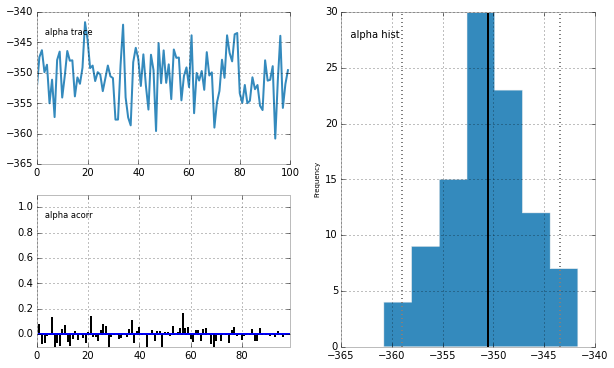

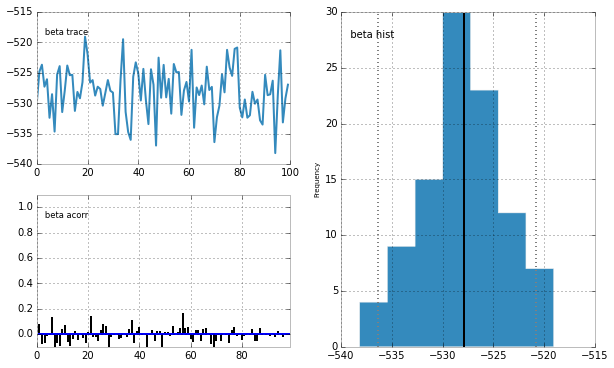

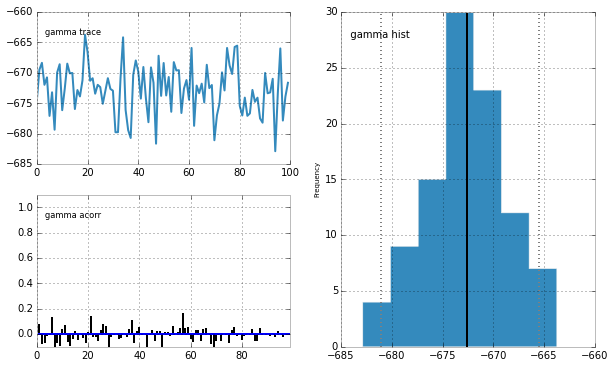

In [18]:
plot(M)

AttributeError: 'MCMC' object has no attribute 'alpha'

SyntaxError: unexpected EOF while parsing (<ipython-input-23-53a37f671625>, line 1)

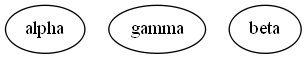

In [2]:
Image("Nice Notebooks\THL_no_thickness.png")

In [ ]:
plot(M)